In [ ]:
%load_ext autoreload
#stas = ['AAK', 'AKTO', 'BVAR', 'KURK', 'MKAR', 'SONM', 'ZALV']
stas = ['AAK', 'AKTO', 'BVAR', 'MKAR', 'ZALV']
basedir = "vdec_signals"

ev_bounds = dict()

ev_bounds['top'] = 50
ev_bounds['bottom'] = 35
ev_bounds['left'] = 60
ev_bounds['right'] =100

phase = 'Pn'


In [ ]:
from sigvisa.explore.doublets.xcorr_pairs import xcorr, xcorr_valid, extract_phase_window
from sigvisa.treegp.gp import GP, GPCov, ll_under_GPprior, gaussian_logp
import seaborn as sns

import sigvisa.explore.wavelet_matching
from sigvisa.explore.wavelet_matching import *


import sigvisa.explore.wavelet_vis
from sigvisa.explore.wavelet_vis import *

%autoreload

sigvisa.explore.wavelet_matching.phase=phase
sigvisa.explore.wavelet_matching.ev_bounds=ev_bounds
sigvisa.explore.wavelet_vis.basedir=basedir
sigvisa.explore.wavelet_vis.stas=stas

In [77]:
from sigvisa.models.ttime import tt_predict

def predict_tt_coord(X, sta, phase):
    ev = Event(lon=X[0], lat=X[1], depth=X[2], time=X[3], mb=4.0)
    return tt_predict(ev, sta, phase)

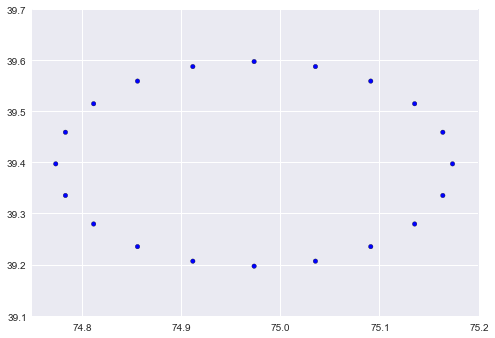

In [292]:
def star_events(center):
    v1 = np.array([0.1, 0.1, 0.0, 0.0])
    v2 = np.array([0.1, -0.1, 0.0, 0.0])
    #v3 = np.array([0.1, 0, 0.0, 0.0])
    #v4 = np.array([0, 0.1, 0.0, 0.0])
    
    events = []
    for c in np.linspace(-2,2, 10):
        events.append(center + v1 *c)
        events.append(center + v2 *c)
        #events.append(center + v3 *c)
        #events.append(center + v4 *c)
    events = np.array(events)
    events[:,3] += np.random.randn(events.shape[0]) * 100000
    return events

def circle_events(center, n, radius = 0.2):
    events = []
    for d in np.linspace(0, 2*np.pi, n+1):
        events.append(center + np.array([np.sin(d) * radius, np.cos(d) * radius, 0, np.random.randn() * 100000]))
    return np.array(events[:n])

def cluster_events(center, n_clusters, cluster_size, cluster_width):
    events = []
    for i in range(n_clusters):
        cluster_center = center + np.array([np.random.randn()*.5, np.random.randn()*.5, 0, 0])
        for k in range(cluster_size):
            events.append(cluster_center + np.array([np.random.randn()*cluster_width, np.random.randn()*cluster_width, 0, np.random.randn() * 100000]))
    return np.array(events)

ev = np.array([74.973, 39.399, 0.0, 1266367142.687])
#events = star_events(ev)
events = circle_events(ev, 20)
#events = cluster_events(ev, 6, 5, 0.03)
scatter(events[:,0], events[:,1])

In [314]:
eyes = []
js = []
for (i, xi) in enumerate(events):
    for (j, xj) in enumerate(events[i+1:,:]):
        d = dist_km((xi[0], xi[1]), (xj[0], xj[1]))
        if d < 15:
            eyes.append(i)
            js.append(j+i+1)
print eyes, js
pairs = (eyes, js)

[0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18] [1, 2, 18, 19, 2, 3, 19, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19]


In [315]:
atime_cov = GPCov(wfn_str="compact2", dfn_str="lld", wfn_params=[1.0,], dfn_params=[80,50])
pick_std = 2.0
pick_var = pick_std**2
rel_std = 0.01
rel_var = rel_std**2

sample_delays=dict()
pred_tts=dict()
sample_tts=dict()
sample_atimes=dict()
sample_picks=dict()

for sta in stas:
    sample_delays[sta] = prior_sample(events, atime_cov, noise_var=0)
    pred_tts[sta] = [predict_tt_coord(xx, sta, 'Pn') for xx in events]
    sample_tts[sta] = sample_delays[sta] + pred_tts[sta]
    sample_atimes[sta] = events[:,3] + sample_tts[sta]
    sample_picks[sta] = sample_atimes[sta] + np.random.randn(len(sample_atimes[sta])) * pick_std

In [316]:
rel_atimes = dict()
for sta in stas:
    rel_atimes[sta] = sample_atimes[sta][eyes] - sample_atimes[sta][js]

In [317]:
from sigvisa.treegp.cover_tree import VectorTree, MatrixTree

pt = VectorTree(events, 1, atime_cov.dfn_str, atime_cov.dfn_params, atime_cov.wfn_str, atime_cov.wfn_params)

def unflatten(fev):
    X_events = np.zeros(events.shape)
    tmp = np.reshape(fev, (events.shape[0], 3))
    X_events[:,0:2] = tmp[:,0:2]
    X_events[:,3] = tmp[:,2]
    return X_events

def flatten(Xev):
    s = Xev[:,[0,1,3]]
    return s.flatten()

def abs_dKdi(X_events, p, i):
    N = X_events.shape[0]
    dKdi = np.zeros((N, N))
    xp =  np.array(X_events[p:p+1,:], copy=True)
    kp = pt.kernel_deriv_wrt_xi(xp, X_events, 0, i)
    dKdi[p,:] = kp
    dKdi[:,p] = kp
    dKdi[p,p] = 0
    return dKdi

def gpllgrad(X_events, y, fK, fdKdi):
    #X_events = unflatten(flat_ev)
    flat_ev = flatten(X_events)
    n = X_events.shape[0]
    grad = np.zeros((len(flat_ev),))
    K = fK(X_events)
    
    L = scipy.linalg.cholesky(K, lower=True)
    ld2 = np.log(np.diag(L)).sum() # this computes .5 * log(det(K))
    alpha = scipy.linalg.cho_solve((L, True), y)
    ll =  -.5 * ( np.dot(y.T, alpha) + n * np.log(2*np.pi)) - ld2

    Kinv = np.linalg.inv(K)
    
    grad_wrt_y = -scipy.linalg.cho_solve((L, True), y)
    
    for idx in range(len(flat_ev)):
        p = idx / 3
        i = idx % 3
        if i < 2:
            dKdi = fdKdi(X_events, p, i)
            
            #X_events[p,i] += 1e-4
            #K2 = fK(X_events)
            #X_events[p,i] -= 1e-4
            #dKdie = (K2-K)/1e-4
            #if np.max(np.abs(dKdie - dKdi)) > .1:
            #    import pdb; pdb.set_trace()
            
            dlldi = .5 * np.dot(alpha.T, np.dot(dKdi, alpha))
            dlldi -= .5 * np.sum(np.sum(np.multiply(Kinv, dKdi)))
        
            grad[idx] = dlldi
    return ll, grad, grad_wrt_y

def absK(Xev):
    K = pt.kernel_matrix(Xev, Xev, False)
    K += np.eye(K.shape[0]) * pick_var
    return K




x0 = flatten(events)
ll, grad, ygrad = gpllgrad(events, sample_picks['MKAR']-events[:,3] - pred_tts['MKAR'], absK, abs_dKdi)
print ll

print grad
print ygrad


-41.3191190021
[-2.86367988  1.09965012  0.          1.81425135 -1.30430126  0.
  2.07350213 -1.84610855  0.          0.12540056 -0.22534241  0.
  0.00292735  0.06464388  0.         -0.09040596  0.00442929  0.          0.4886531
  1.58464576  0.         -0.25855371 -0.21504324  0.          0.94625697
  1.25681627  0.          0.28762431  0.41372213  0.         -1.21958361
 -0.58040259  0.         -0.52650759 -0.35547284  0.         -0.07630986
 -0.45722677  0.          0.12028195 -0.56092911  0.          0.0842729
  0.30886835  0.          0.16099682  0.17590413  0.          0.36651323
 -0.37654847  0.         -1.26142082  1.22112654  0.          0.99212086
 -0.50932648  0.         -1.16634011  0.29223953  0.        ]
[-0.64367372  0.4406965   0.71842442  0.14893617  0.16057148  0.00203443
  0.46271028 -0.0654467   0.31124603  0.09365053 -0.39217654 -0.30840869
 -0.26452844 -0.22969571  0.13206734  0.27376492  0.38817127 -0.9494297
  0.35468764 -0.33260256]


In [318]:

def dydX(X_events, picks, sta, eps=1e-4):
    # how does changing lon by epsilon affect observed pick time?
    tts = np.array([predict_tt_coord(x, sta, 'Pn') for x in X_events])
    lon_tts = np.array([predict_tt_coord((x[0]+eps, x[1], x[2], x[3]), sta, 'Pn') for x in X_events])
    lat_tts = np.array([predict_tt_coord((x[0], x[1]+eps, x[2], x[3]), sta, 'Pn') for x in X_events])
    
    dtt_dlon = (lon_tts - tts) / eps
    dtt_dlat = (lat_tts - tts) / eps
    
    dys = np.ones((X_events.shape[0]*3,))
    dys[0::3] = dtt_dlon
    dys[1::3] = dtt_dlat
    return dys
    
def location_energy(X_events, picks):
    ll = 0
    grad = None
    for sta in stas:
        pred_tts = [predict_tt_coord(x, sta, 'Pn') for x in X_events]
        pred_ats = pred_tts + X_events[:,3]
        residuals = picks[sta] - pred_ats
        gp_ll, gpgrad, ygrad = gpllgrad(X_events, residuals, absK, abs_dKdi) #ll_under_GPprior(X_events, residuals, atime_cov, pick_var)
        dys = dydX(X_events, picks, sta)
        
        ll += gp_ll
        
        dys[::3] *= ygrad
        dys[1::3] *= ygrad
        dys[2::3] *= ygrad
        
        fullgrad = gpgrad - dys
        
        grad = fullgrad if grad is None else grad + fullgrad
    return -ll, -grad



In [319]:
import scipy.optimize



def f(flat_ev):
    X_events = unflatten(flat_ev)
    try:
        nll, ngrad = location_energy(X_events, sample_picks)
        #print 'returning', nll
        #print nll
        return nll,ngrad
    except Exception as e:
        print e
        return 999999999, np.zeros(flat_ev.shape)

x0 = flatten(events)
#print f(x0)

r = scipy.optimize.minimize(f, x0, options={'disp': True}, jac=True, method="BFGS")
#print r

"""ll1,g1 = f(x0)
x0[-1] += 1e-4
ll2,g2 = f(x0)
print (ll2-ll1)/1e-4
print g1"""

EarthModel: requesting travel time for impossible phase.
         Current function value: 195.387416
         Iterations: 67
         Function evaluations: 133
         Gradient evaluations: 123


'll1,g1 = f(x0)\nx0[-1] += 1e-4\nll2,g2 = f(x0)\nprint (ll2-ll1)/1e-4\nprint g1'

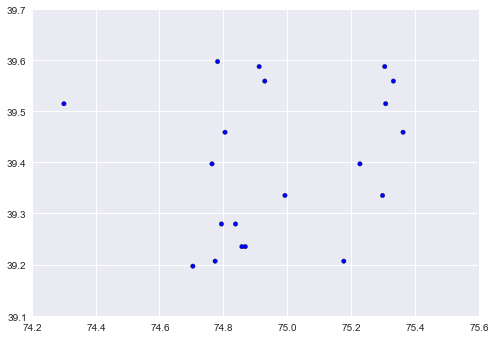

In [320]:
#print unflatten(r.x)
loc_events = unflatten(r.x)
scatter(loc_events[:,0], events[:,1])

In [321]:

def expand_to_rel(K, pairs, pick_var, rel_var):
    N = K.shape[0]
    eyes, js = pairs
    NN = N + len(eyes)
    KK = np.zeros((NN, NN))
    KK[0:N, 0:N] = K + np.eye(N) * pick_var
    
    # cov(a, c-d) = cov(a,c) + cov(a,d)
    # cov(a-b, c-d) = cov(a,c) + cov(a,d) + cov(b,c) + cov(b,d)

    offdiag = K[eyes,:] + K[js,:]
    KK[N:NN,:N] = offdiag
    KK[:N, N:NN] = offdiag.T
    
    #eyes = 
    
    diag = K[np.ix_(eyes,eyes)] + K[np.ix_(eyes,js)] + K[np.ix_(js, eyes)] + K[np.ix_(js, js)]
    diag += np.eye(diag.shape[0]) * rel_var
    KK[N:NN,N:NN] = diag
    #print "returning", K.shape, KK.shape
    return KK
    
def rel_cov(X_events, pairs, cov, pick_var, rel_var, predict_tree=None):
    if predict_tree is None:
        predict_tree = VectorTree(X_events, 1, cov.dfn_str, cov.dfn_params, cov.wfn_str, cov.wfn_params)
        
    K = predict_tree.kernel_matrix(X_events, X_events, False)

    return expand_to_rel(K, pairs, pick_var, rel_var), predict_tree
        
def rel_dKdi(predict_tree, X_events, p, i, pairs):
    #print "dkdi-ing"
    dKdi = abs_dKdi(X_events, p, i)
    #print "got dKdi", dKdi.shape
    return expand_to_rel(dKdi, pairs, 0.0, 0.0)
    
    
def relK(Xev):
    return rel_cov(Xev, pairs, atime_cov, pick_var, rel_var, pt)[0]

def reldK(Xev, p, i):
    return rel_dKdi(pt, Xev, p, i, pairs)
    
#KK, pt = rel_cov(events, (eyes, js), atime_cov, 4.0, 4.0)


In [322]:

def rel_dydX(X_events, picks, pairs, sta, eps=1e-4):
    # how does changing lon by epsilon affect observed pick time?
    dys = dydX(X_events, picks, sta, eps=eps)
    N = len(dys)
    eyes, js = pairs
    full_dys = np.zeros((N + len(eyes)))
    full_dys[:N] = dys
    full_dys[N:] = dys[eyes] - dys[js]
    return full_dys

def rel_energy(X_events, picks, pairs, rel_offsets):
    ll = 0
    grad=None
    eyes, js = pairs
    for sta in stas:
        pred_tts = [predict_tt_coord(x, sta, 'Pn') for x in X_events]
        pred_ats = pred_tts + X_events[:,3]
        residuals = picks[sta] - pred_ats
        
        pred_offsets = pred_ats[eyes] - pred_ats[js]
        offset_residuals = rel_offsets[sta] - pred_offsets
        obs = np.concatenate([residuals, offset_residuals])
        
        
        #K = rel_cov(X_events, pairs, atime_cov, pick_var, rel_var)
        gp_ll, gpgrad, ygrad = gpllgrad(X_events, obs, relK, reldK)
        
        ll += gp_ll
        
        dys = rel_dydX(X_events, picks, pairs, sta)
        N = X_events.shape[0]
        dLdtheta = np.zeros((3*N),)
        for theta_i in range(3*N):
            j = theta_i / 3
            
            # this param can affect the GP directly through y[j],
            # but also indirectly through y[N+k] where k is any
            # index such that j = eyes[k] or j = js[k]
            dLdtheta[theta_i] = ygrad[j] * dys[theta_i]
            for k in range(len(eyes)):
                if eyes[k] == j:
                    dLdtheta[theta_i] += ygrad[N+k] * dys[theta_i]
                elif js[k] == j:
                    dLdtheta[theta_i] -= ygrad[N+k] * dys[theta_i]
        
        
        #
        #dys[::3] *= ygrad
        #dys[1::3] *= ygrad
        #dys[2::3] *= ygrad
        
        
        
        # now we have ygrad[:N] is the derivative of the GP wrt each pick residual, and ygrad[N:] gives derivatives wrt each relative residual
        # and dys gives the derivative of the pick/relative residuals wrt each event param.
        # so dys should be three times as long

        # 
        
        fullgrad = gpgrad - dLdtheta
        
        grad = fullgrad if grad is None else grad + fullgrad
        
        
        grad = gpgrad if grad is None else grad + gpgrad
    return -ll, -grad

In [329]:
mult = np.array([1.0 if (n % 3 == 2) else 100.0 for n in range(len(flatten(loc_events)))])

shift = np.array([np.mean(events[:,3]) if (n % 3 == 2) else 0.0 for n in range(len(flatten(loc_events)))])

#print shift
#mult = np.array([1.0 if (n % 3 == 2) else 1.0 for n in range(len(flatten(loc_events)))])


def ff(flat_ev):
    
    X_events = unflatten(flat_ev / mult + shift)
    try:
        nll,ngrad = rel_energy(X_events, sample_picks, pairs, rel_atimes)
        print 'returning', nll
        return nll, ngrad / mult
    except Exception as e:
        print e
        return 999999999, np.zeros(flat_ev.shape)

x0 = flatten(loc_events) * mult - shift
#x0 = flatten(events) * mult - shift

r = scipy.optimize.minimize(ff, x0, options={'disp': True}, jac=True, method="BFGS")
#r = scipy.optimize.minimize(ff, r.x, options={'disp': True}, jac=True, method="CG")

#x = x0
for i in range(1):
    print "round"
    nll, ngrad = ff(r.x)
    x = r.x - ngrad * 0.001
    print x
    r = scipy.optimize.minimize(ff, x, options={'disp': True}, jac=True, method="BFGS")

#ll1, g1 = ff(x0)
#x0[-4] += 1e-4
#ll2, g2 = ff(x0)
#print (ll2-ll1)/1e-4
#print g1

#r = scipy.optimize.minimize(ff, r.x, options={'disp': True}, jac=True, method="TNC")



returning 1656554.46843
returning 1656554.46843
EarthModel: requesting travel time for impossible phase.
EarthModel: requesting travel time for impossible phase.
EarthModel: requesting travel time for impossible phase.
EarthModel: requesting travel time for impossible phase.
returning 1.38550517899e+12
returning 1224362.72865
returning 3088174.50532
returning 1155145.47031
returning 1274040.32539
returning 1136567.36852
returning 1111070.67052
returning 1088087.61004
returning 1045760.08713
returning 991849.681295
returning 907963.224447
returning 781431.19675
returning 659197.404686
returning 779082.838535
returning 618060.071962
returning 627443.998035
returning 599394.877781
returning 616980.988107
returning 592967.244681
returning 581309.785455
returning 568908.598735
returning 545482.126707
returning 599157.504824
returning 539937.450124
returning 528978.60359
returning 490094.703274
returning 447421.519904
returning 364040.261266
returning 300235.649485
returning 341115.552418
re

In [330]:
rel_events = unflatten(r.x / mult + shift) 
#print r

In [331]:
def print_obs(ev, sta):
    pred_tts = [predict_tt_coord(x, sta, 'Pn') for x in ev]
    pred_ats = pred_tts + ev[:,3]
    residuals = sample_picks[sta] - pred_ats
    
    pred_offsets = pred_ats[eyes] - pred_ats[js]
    offset_residuals = rel_atimes[sta] - pred_offsets
    obs = np.concatenate([residuals, offset_residuals])
    
    print residuals, np.sum(residuals**2)
    print offset_residuals, np.sum(offset_residuals**2)
    
print_obs(rel_events, "MKAR")

[-1.51574564 -2.36360192 -3.8613553  -1.96161866 -2.32473111 -1.36360788
 -2.46918917  0.07535553 -1.24705863 -0.27229238  1.63590097  1.13796878
  1.1176405   1.41806865  0.18772769 -0.40283608 -1.05573463  3.77099705
 -1.78286457 -0.59466028] 67.9337084012
[ -3.18730426e+00  -2.63711691e+00  -4.04297709e+00  -2.45175028e+00
   5.50187349e-01   7.64717817e-01   7.35553980e-01   2.14530468e-01
   2.44360209e-01   2.98297405e-02  -2.61639595e-01  -2.91469336e-01
  -7.65111923e-01  -4.73642588e-01  -8.59070301e-01  -3.85427713e-01
  -6.34058475e-01  -2.48630762e-01  -2.61899948e-01  -1.32691860e-02
  -1.09553337e-02   2.31385231e-03  -7.55758286e-02  -7.78896809e-02
  -2.58742332e-01  -1.80852652e-01  -3.29021931e-01  -1.48169279e-01
  -1.10815525e-01   3.73537540e-02   4.34002876e-02   6.04653358e-03
  -8.02612305e-03  -1.40726566e-02   8.93712044e-02   1.03443861e-01
   1.37489319e-01   3.40454578e-02   1.62527227e+00   1.59122682e+00] 48.8574056853


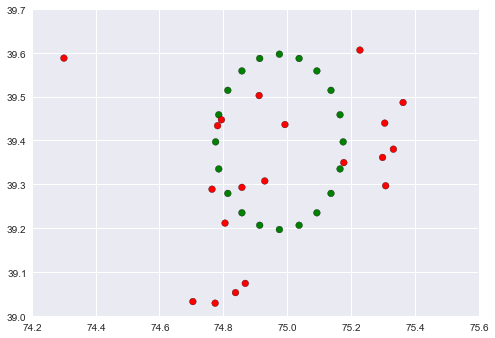

In [332]:
scatter(events[:,0], events[:,1], c='g', s=45)

scatter(loc_events[:,0], loc_events[:,1], c='r', s=45)


In [333]:
from sigvisa.analyze import find_matching, f1_and_error
indices = find_matching(events, rel_events)

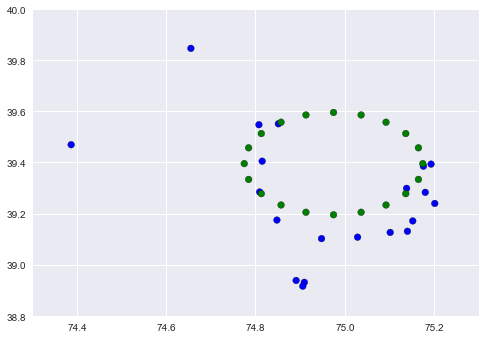

In [334]:
scatter(rel_events[:,0], rel_events[:,1], c='b', s=45)
scatter(events[:,0], events[:,1], c='g', s=45)

In [276]:
f, p, r, err = f1_and_error(events, loc_events)
print f
print p
print r
print err

100.0
100.0
100.0
(16.996343663774461, 10.396762688334078)
